In [49]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import sqlite3



In [50]:
file_path = 'Data/airports.csv'

In [51]:
df = pd.read_csv(file_path)

In [52]:
df.head(5)

,faa,name,lat,lon,alt,tz,dst,tzone
0,AAF,Apalachicola Regional Airport,29.727501,-85.027496,20,-5.0,A,America/New_York
1,AAP,Andrau Airpark,29.722500,-95.588303,79,-6.0,A,America/Chicago
2,ABE,Lehigh Valley International Airport,40.652100,-75.440804,393,-5.0,A,America/New_York
3,ABI,Abilene Regional Airport,32.411301,-99.681900,1791,-6.0,A,America/Chicago
4,ABL,Ambler Airport,67.106300,-157.856989,334,-9.0,A,America/Anchorage


## Exploration Plotly Express scatter_geo

In [53]:
px.scatter_geo(df, lat="lat", lon="lon",  color="alt", projection="natural earth")


JFK Position: lat = 40.63980103, lon = -73.77890015


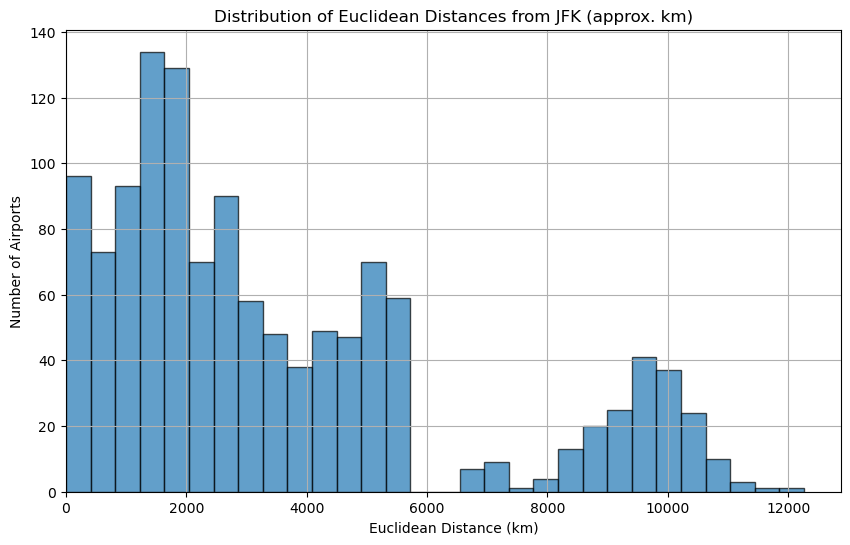

In [ ]:

jfk_row = df[df['name'].str.contains("John F Kennedy International Airport", case=False, na=False)]
if jfk_row.empty:
    raise ValueError("JFK airport not found in the dataset!")
else:
    jfk = jfk_row.iloc[0]
    jfk_lat_deg = jfk['lat']  # degrees
    jfk_lon_deg = jfk['lon']  # degrees
    print(f"JFK Position: lat = {jfk_lat_deg}, lon = {jfk_lon_deg}")

# Compute Euclidean distance in degrees
df['euclidean_distance_deg'] = np.sqrt((df['lat'] - jfk_lat_deg)**2 + (df['lon'] - jfk_lon_deg)**2)

# Filter out unrealistic distances (>180°)
df_euclid = df[df['euclidean_distance_deg'] <= 180].copy()

# Convert Euclidean distance from degrees to kilometers 1 degree ~ 111 km)
df_euclid['euclidean_distance_km'] = df_euclid['euclidean_distance_deg'] * 111

# Plot histogram for the Euclidean distances 
plt.figure(figsize=(10, 6))
plt.hist(df_euclid['euclidean_distance_km'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Euclidean Distance (km)')
plt.ylabel('Number of Airports')
plt.title('Distribution of Euclidean Distances from JFK (approx. km)')
plt.grid(True)
plt.xlim(left=0)
plt.show()



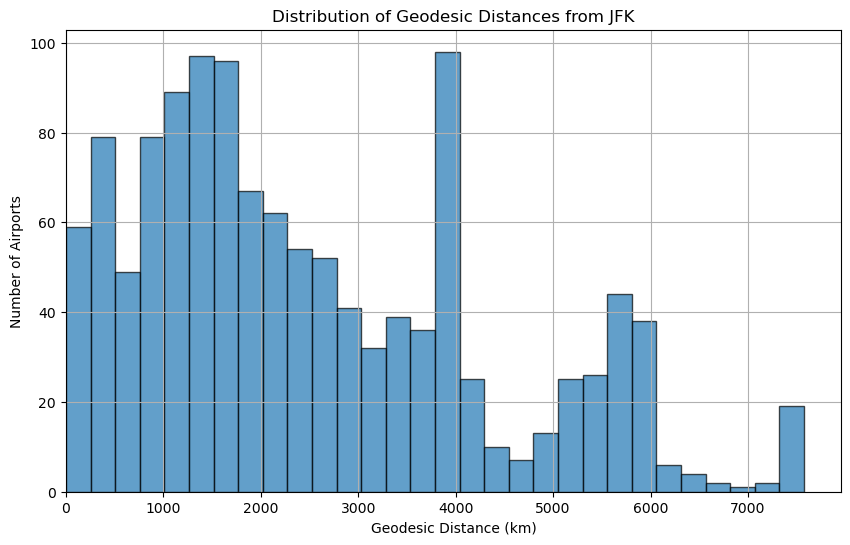

In [ ]:

R = 6371

# Convert latitude and longitude values from degrees to radians
lat_rad = np.radians(df['lat'])
lon_rad = np.radians(df['lon'])
jfk_lat_rad = np.radians(jfk_lat_deg)
jfk_lon_rad = np.radians(jfk_lon_deg)

# Compute differences in radians
dphi = lat_rad - jfk_lat_rad        # Δφ
dlambda = lon_rad - jfk_lon_rad     # Δλ
phi_m = (lat_rad + jfk_lat_rad) / 2   # Midpoint latitude

# Apply the geodesic distance formula:
term1 = 2 * np.sin(dphi / 2) * np.cos(dlambda / 2)
term2 = 2 * np.cos(phi_m) * np.sin(dlambda / 2)
df['geodesic_distance_km'] = R * np.sqrt(term1**2 + term2**2)

# Filter out any unrealistic values 
df_geo = df[df['geodesic_distance_km'] <= 20000].copy()

# Plot histogram for the geodesic distances 
plt.figure(figsize=(10, 6))
plt.hist(df_geo['geodesic_distance_km'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Geodesic Distance (km)')
plt.ylabel('Number of Airports')
plt.title('Distribution of Geodesic Distances from JFK')
plt.grid(True)
plt.xlim(left=0)
plt.show()


In [56]:
conn = sqlite3.Connection('Data/flights_database.db')
cursor = conn.cursor()
query_flights = f'SELECT * FROM flights'
cursor.execute(query_flights)
cursor.description
data_rows = cursor.fetchall()
flights_df = pd.DataFrame(data_rows, columns=[col[0] for col in cursor.description])
flights_df

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2023,1,1,1.0,2038,203.0,328.0,3,205.0,UA,628,N25201,EWR,SMF,367.0,2500.0,20.0,38.0,1.672603e+09
1,2023,1,1,18.0,2300,78.0,228.0,135,53.0,DL,393,N830DN,JFK,ATL,108.0,760.0,23.0,0.0,1.672614e+09
2,2023,1,1,31.0,2344,47.0,500.0,426,34.0,B6,371,N807JB,JFK,BQN,190.0,1576.0,23.0,44.0,1.672614e+09
3,2023,1,1,33.0,2140,173.0,238.0,2352,166.0,B6,1053,N265JB,JFK,CHS,108.0,636.0,21.0,40.0,1.672607e+09
4,2023,1,1,36.0,2048,228.0,223.0,2252,211.0,UA,219,N17730,EWR,DTW,80.0,488.0,20.0,48.0,1.672603e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435347,2023,12,31,2218.0,2224,-6.0,304.0,325,-21.0,NK,364,N647NK,EWR,SJU,203.0,1608.0,22.0,24.0,1.704060e+09
435348,2023,12,31,2243.0,2150,53.0,143.0,56,47.0,B6,367,N566JB,JFK,PBI,149.0,1028.0,21.0,50.0,1.704056e+09
435349,2023,12,31,2248.0,2259,-11.0,338.0,350,-12.0,B6,283,N793JB,JFK,PSE,207.0,1617.0,22.0,59.0,1.704060e+09
435350,2023,12,31,2326.0,2325,1.0,412.0,405,7.0,B6,313,N807JB,JFK,BQN,199.0,1576.0,23.0,25.0,1.704064e+09


In [ ]:
# Query the airports table from the same database
query_airports = "SELECT * FROM airports"
cursor.execute(query_airports)
airports_rows = cursor.fetchall()
airports_df = pd.DataFrame(airports_rows, columns=[col[0] for col in cursor.description])

jfk_airport = airports_df[airports_df['faa'] == 'JFK'].iloc[0]
jfk_lat_deg = jfk_airport['lat']
jfk_lon_deg = jfk_airport['lon']
print(f"JFK airport: lat = {jfk_lat_deg}, lon = {jfk_lon_deg}")

# Compute the geodesic distance for each airport relative to JFK.
R = 6371  # Earth's radius in kilometers
airports_df['lat_rad'] = np.radians(airports_df['lat'])
airports_df['lon_rad'] = np.radians(airports_df['lon'])
jfk_lat_rad = np.radians(jfk_lat_deg)
jfk_lon_rad = np.radians(jfk_lon_deg)

dphi = airports_df['lat_rad'] - jfk_lat_rad      # Δφ
dlambda = airports_df['lon_rad'] - jfk_lon_rad    # Δλ
phi_m = (airports_df['lat_rad'] + jfk_lat_rad) / 2  # Midpoint latitude

# Apply the geodesic formula:
airports_df['computed_distance_km'] = R * np.sqrt((2 * np.sin(dphi/2) * np.cos(dlambda/2))**2 +
                                                  (2 * np.cos(phi_m) * np.sin(dlambda/2))**2)


JFK airport: lat = 40.63980103, lon = -73.77890015


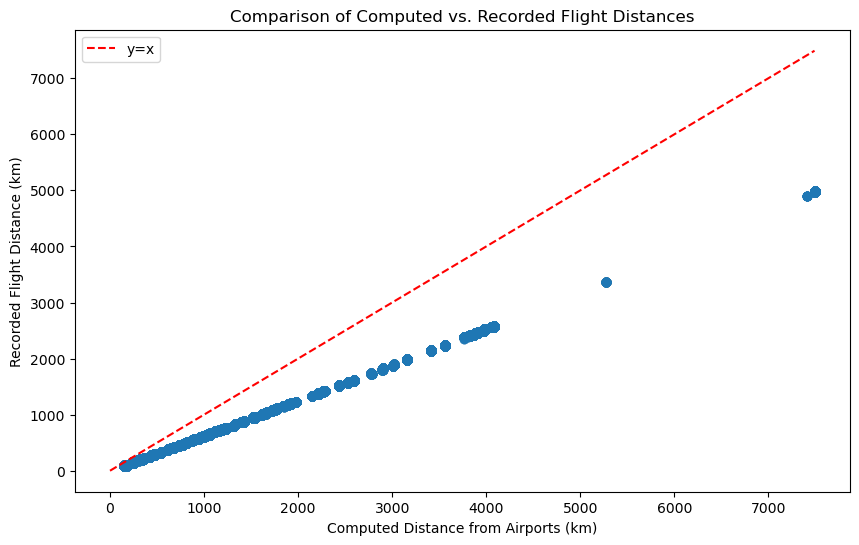

Mean difference (recorded - computed): -582.5094313754007
Correlation between recorded and computed distances: 0.9997649759753489


In [ ]:
# Merge flights_df with the computed distances from the airports table.
merged_df = flights_df.merge(airports_df[['faa', 'computed_distance_km']],
                             left_on='dest', right_on='faa', how='left')

# compare computed distances
# Plot a scatter plot with a y=x reference line.
plt.figure(figsize=(10,6))
plt.scatter(merged_df['computed_distance_km'], merged_df['distance'], alpha=0.5)
plt.xlabel('Computed Distance from Airports (km)')
plt.ylabel('Recorded Flight Distance (km)')
plt.title('Comparison of Computed vs. Recorded Flight Distances')
max_val = max(merged_df['computed_distance_km'].max(), merged_df['distance'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label="y=x")
plt.legend()
plt.show()

# Also, print summary statistics of the difference.
diff = merged_df['distance'] - merged_df['computed_distance_km']
print("Mean difference (recorded - computed):", diff.mean())
print("Correlation between recorded and computed distances:", 
      merged_df['distance'].corr(merged_df['computed_distance_km']))


In [ ]:
# Get the unique origin airport codes from the flights table
origin_codes = flights_df['origin'].unique()
print("Origin airport codes:", origin_codes)

# filter it to include only the airports present in the flights origin.
nyc_airports_df = airports_df[airports_df['faa'].isin(origin_codes)].copy()

# Display the resulting DataFrame
nyc_airports_df.head()


Origin airport codes: ['EWR' 'JFK' 'LGA']


,faa,name,lat,lon,alt,tz,dst,tzone,lat_rad,lon_rad,computed_distance_km
364,EWR,Newark Liberty International Airport,40.692501,-74.168701,18.0,-5.0,A,America/New_York,0.710218,-1.294488,33.395273
588,JFK,John F Kennedy International Airport,40.639801,-73.778900,13.0,-5.0,A,America/New_York,0.709298,-1.287685,0.000000
655,LGA,La Guardia Airport,40.777199,-73.872597,21.0,-5.0,A,America/New_York,0.711696,-1.289320,17.198498


In [ ]:
def plot_destinations(month, day, origin_airport):
    """
    Plots all destination airports for flights on a given month and day from a specified NYC airport.
    
    Parameters:
        month (int): Month number (e.g., 1 for January).
        day (int): Day of the month.
        origin_airport (str): faa code of the NYC origin airport (e.g., 'JFK', 'LGA', 'EWR').
    """
    # Filter flights for the specified day and origin
    flights_on_day = flights_df[
        (flights_df['month'] == month) &
        (flights_df['day'] == day) &
        (flights_df['origin'] == origin_airport)
    ]
    
    if flights_on_day.empty:
        print(f"No flights found on {month}/{day} from {origin_airport}.")
        return
    
    # Get unique destination codes from these flights
    dest_codes = flights_on_day['dest'].unique()
    
    # Filter the airports DataFrame to get information on these destination airports
    dest_airports = airports_df[airports_df['faa'].isin(dest_codes)].copy()
    
    # (Optional) Count the number of flights per destination to use for marker sizing
    flight_counts = flights_on_day['dest'].value_counts().rename_axis('faa').reset_index(name='count')
    dest_airports = dest_airports.merge(flight_counts, on='FAA', how='left')
    
    # Create a scatter_geo figure 
    fig = px.scatter_geo(dest_airports,
                         lat="lat", lon="lon",
                         hover_name="name",
                         size="count",  # Marker size reflects number of flights
                         title=f"Destinations from {origin_airport} on {month}/{day}",
                         projection="natural earth")
    fig.show()


In [ ]:
def flight_statistics(month, day, origin_airport):
    """
    Computes and returns statistics for flights departing from a given NYC airport on a specified day.
    
    Parameters:
        month (int): The month (e.g., 6 for June).
        day (int): The day of the month.
        origin_airport (str): The FAA code for the NYC origin airport (e.g., 'JFK', 'LGA', 'EWR').
    
    Returns:
        dict: A dictionary containing:
              - 'num_flights': Total number of flights on that day.
              - 'num_unique_destinations': Number of unique destination airports.
              - 'most_frequent_destination': The destination visited most often.
              - 'most_frequent_destination_count': Number of flights to the most frequent destination.
    """
    # Filter the flights for the specified day and origin airport
    flights_on_day = flights_df[
        (flights_df['month'] == month) &
        (flights_df['day'] == day) &
        (flights_df['origin'] == origin_airport)
    ]
    
    if flights_on_day.empty:
        print(f"No flights found on {month}/{day} from {origin_airport}.")
        return {}
    
    # Compute statistics
    num_flights = len(flights_on_day)
    num_unique_destinations = flights_on_day['dest'].nunique()
    
    # Identify the destination visited most frequently
    dest_counts = flights_on_day['dest'].value_counts()
    most_frequent_destination = dest_counts.idxmax()
    most_frequent_destination_count = dest_counts.max()
    
    
    stats = {
        "num_flights": num_flights,
        "num_unique_destinations": num_unique_destinations,
        "most_frequent_destination": most_frequent_destination,
        "most_frequent_destination_count": most_frequent_destination_count
    }
    
    return stats

# Example usage:
stats = flight_statistics(6, 15, 'JFK')
print("Flight statistics on 6/15 from JFK:")
for key, value in stats.items():
    print(f"{key}: {value}")


Flight statistics on 6/15 from JFK:
num_flights: 364
num_unique_destinations: 68
most_frequent_destination: LAX
most_frequent_destination_count: 29
